In [1]:
from modules.tweet_data import read_raw_data
from modules.topics import TopicSeries

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import spacy
import pickle

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Topic Model Estimation

In [2]:
# Load tweet and market data
tweet_df = read_raw_data()

es = pd.read_csv('data/spx.csv')
es.Date = pd.to_datetime(es.Date +' ' +'15:45')
es.set_index('Date', inplace=True)
date_range = es['2011-12-30':'2020-5-31'].index
del es


Reading data


## Daily topics

In [4]:
# Calculate daily topic models for all tweets in date range
# Functionality is in TopicSeries class in modules.topics
ts=TopicSeries()
ts.fit(tweet_df, date_range)
ts.save('topics' + '-' + str(date_range[0].date()) + '-' + str(date_range[-1].date()) + '.p')
    

## Daily topics for Fintwit

In [5]:
# Merge tweet data with user classification data
classi = pd.read_csv('data/handle_class.csv')
tweet_df = pd.merge(tweet_df,classi[['class','handle','subclass']],on=['handle'], right_index=True)
# Need to resort by index as merge messes up with datetime indexing
tweet_df.sort_index(inplace=True)
tweet_df = tweet_df[tweet_df['class'] == 'fintwit']

In [ ]:
# Calculate daily topic models for all tweets in date range, only for Fintwit
ts=TopicSeries()
ts.fit(tweet_df, date_range)
ts.save('data/topics-fintwit' + '-' + str(date_range[0].date()) + '-' + str(date_range[-1].date()) + '.p')

# Features

In [2]:
ts = pickle.load(open('data/topics-2011-12-30-2020-05-29.p','rb'))

In [3]:
dates = sorted(list(ts.nmf_dict.keys()))
date_dict = {date:i for i, date in enumerate(dates)}

# Estimate reconstruction error. For a days tweets, see model from previous day. 
# Use it to transform data, calculate reconstruction error
# The feature is the ratio between the reconstruction error in the original model with the new reconstruction error
# To standarize for weekends
model_err, new_err = ts.calc_rec_error(tweet_df, date_range[1:])

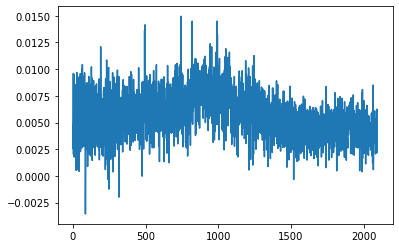

In [6]:
plt.plot(np.array(model_err) / np.array(new_err)-1)
plt.title('Reconstruction Error Ratio');

In [4]:
# Obtain top 20 words for each topic by weight

top_words_list = []
top_args_list = []
top_proba_list = []
top_display = 20

for date in dates:
    print(date,end="\r")
    top_words = []
    top_args = []
    top_proba  = []
    word_features =  ts.tfidf_dict[date].get_feature_names()
    for topic_idx, topic in enumerate(ts.nmf_dict[date].components_):
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_proba.append(sorted(topic)[::-1][:top_display])
        top_words.append([word_features[i] for i in top_words_idx])
        top_args.append(top_words_idx)
    top_words_list.append(top_words)
    top_args_list.append(top_args)
    top_proba_list.append(top_proba)

2016-01-11


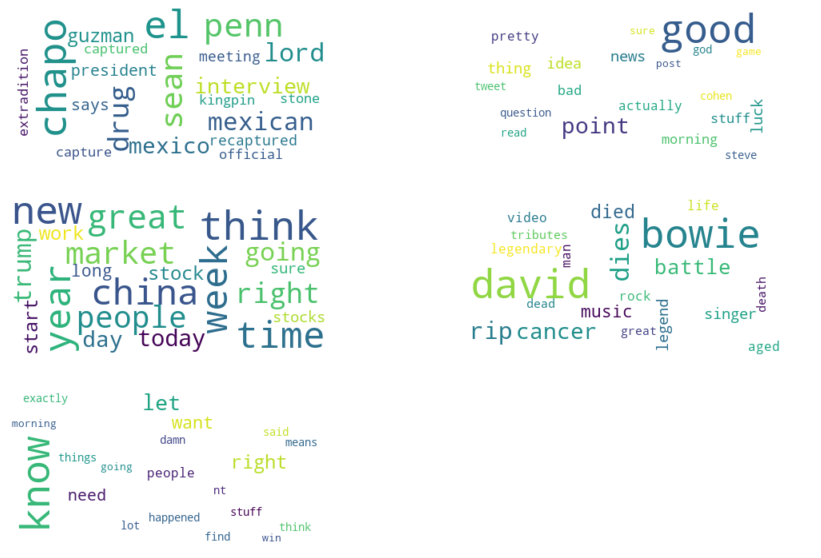

In [25]:
day = date_dict['2016-01-11']

def word_clouds(day):
    """
    Plot 5 word clouds for each day, top 20 words per each topic.
    Uses wordcloud library
    """
    print(dates[day])
    wc = WordCloud(max_font_size=50, contour_width=3, background_color='white')

    fig, ax = plt.subplots(3,2,figsize=(15,10))
    ax = ax.ravel()
    for i in range(5):
        wordcloud = wc.generate_from_frequencies({q:t for t, q in zip(top_proba_list[day][i],top_words_list[day][i])})
        ax[i].imshow(wordcloud, interpolation="bilinear")
        ax[i].axis("off")
    ax[5].axis("off");

word_clouds(day)

In [9]:

nlp_mid = spacy.load('en_core_web_md')

# Obtain GloVe representations for each of 20 words in each topic
# Estimate the mean of each set of 20 words
concat_words = [[' '.join(top_words) for top_words in sub_top_list] for sub_top_list in top_words_list]
word_vectors = [[nlp_mid(topic_words).vector for topic_words in concat_word] for concat_word in concat_words]

# Topic coherence is the average of all cosine similarities between each of 5 vectors for each topic
topic_coherence = []
# Topic coherence difference between day i and i+1
topic_coherence_diff = []

n_topics = 5
den = (n_topics**2-n_topics)
for i in range(len(word_vectors)-1):
    cs = cosine_similarity(word_vectors[i] + word_vectors[i+1])
    # Topic coherence
    tc = (cs[n_topics:2*n_topics,n_topics:2*n_topics].sum() \
        - cs[n_topics:2*n_topics,n_topics:2*n_topics].diagonal().sum())/den
    topic_coherence.append(tc)
    # Topic coherence difference between day i and i+1
    tcd = cs[0:n_topics,n_topics:2*n_topics].max(axis=1).mean()
    topic_coherence_diff.append(tcd) 


In [1]:
# Add features to nmf_features DataFrame
nmf_features = pd.DataFrame(index = dates[1:])
nmf_features['topic_coherence'] = topic_coherence
nmf_features['topic_coherence_diff'] = topic_coherence_diff
nmf_features['recon_ratio'] = np.array(model_err) / np.array(new_err)-1
nmf_features.index.rename('Date', inplace=True)

nmf_features.head()

NameError: name 'pd' is not defined

In [14]:
# Save features to nmf_features.csv
nmf_features.to_csv('data/nmf_features.csv')

2020-03-20


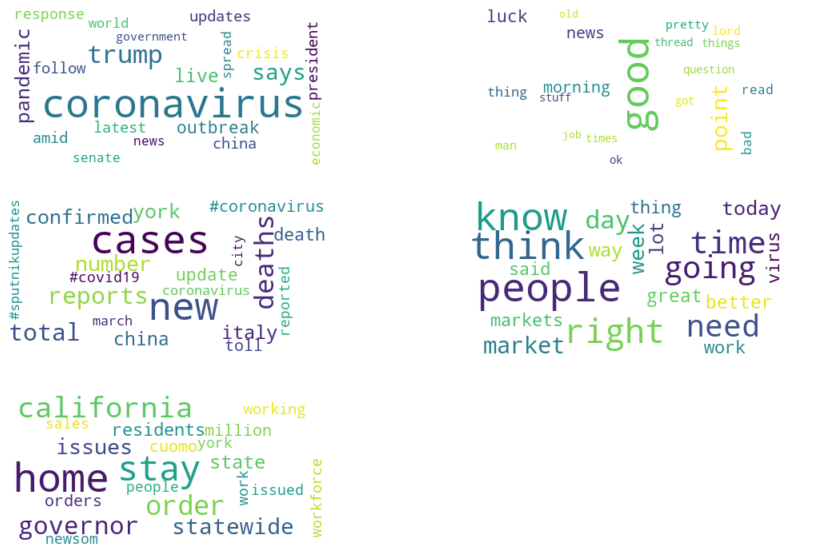

In [22]:
# Example
day = date_dict['2020-03-20']

word_clouds(day)

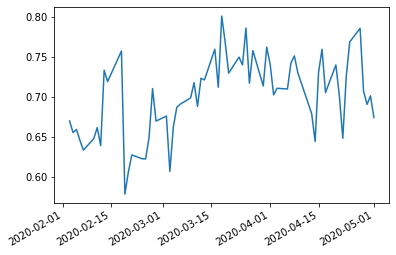

In [26]:
#corona
nmf_features.index = pd.to_datetime(nmf_features.index)
nmf_features['2020-02-01':'2020-05-01'].topic_coherence.plot();

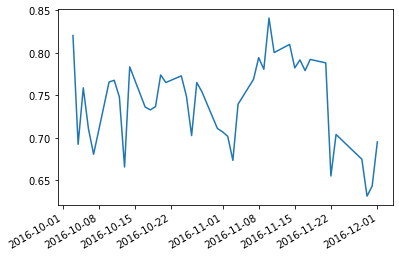

In [27]:
#election
nmf_features['2016-10-01':'2016-12-01'].topic_coherence.plot();